# Late Neanderthals - alleles at non-synonymous sites from the catalog

One of the reviewers asked about the alleles carried by the 5 late Neanderthals at the positions from the catalog of fixed non-synonymous changes.

Now, we cannot really use those samples to "refine" the catalog, due to the low coverage nature of all samples.

Remember the endless discussions about whether we can trust the genotype calls from El Sidron exome capture (which has 12X coverage?). The outcome of those discussions was that El Sidron's genotype calls can't really be trusted. People's favorite fixed changes were kicked out because El Sidron was called heterozygous at sites which, for example, showed 10 reads supporting the archaic state and 2 reads supporting modern human state. True heterozygote? Sequencing error? Contamination? We can't say.

For obvious reasons, this is even more true for ~2X samples. We could pretend that we can genotype 12X samples, but we definitely can't genotype those 2X samples at all.

Alas, reviewers' comments have to be addressed, so here it goes. At least we can show that we tried and present a pretty colorful plot.

If you don't like reading my beautiful, idiomatic Python code, scroll to the very end of this notebook. I won't be offended.

In [1]:
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
import pysam
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

## Loading the non-synonymous sites from the catalog

Load the catalog of non-synonymous fixed modern-human-specific autosomal differences:

In [3]:
catalog = (pd
           .read_table('/mnt/expressions/mp/Projects/catalogs/final_version/HumDer_SNCs/fixed/fixed_HumDer_SNCs_merged_genic_ccds_nonsyn.tsv')
           .rename(columns={'Chrom'       : 'chrom',
                            'Pos'         : 'pos',
                            'Consequence' : 'consequence',
                            'Ancestor'    : 'ancestral',
                            'Human'       : 'derived',
                            'States'      : 'archaics'})
          )[['chrom', 'pos', 'consequence', 'ancestral', 'derived', 'archaics']]

Split the column with archaics states (like 'A/A,A/H,A/A,A/A' in the order Vindija, Sidron, Altai, Denisovan) into individual columns and drop the original column:

In [4]:
catalog = catalog.join(
    catalog['archaics']
    .apply(lambda x: pd.Series(x.split(',')))
    .rename(columns={0:'Vindija', 1:'ElSidron', 2:'Altai', 3:'Denisovan'})) \
    .drop(labels=['archaics', 'ElSidron'], axis=1)

In [5]:
catalog.head()

,chrom,pos,consequence,ancestral,derived,Vindija,Altai,Denisovan
0,X,36156570,NON_SYNONYMOUS_CODING,A,G,./.,A/A,A/A
1,X,76939325,NON_SYNONYMOUS_CODING,C,G,./.,A/A,A/A
2,X,131212487,NON_SYNONYMOUS_CODING,C,G,A/A,A/A,A/A
3,X,152128250,NON_SYNONYMOUS_CODING,G,A,A/A,A/A,A/A
4,X,153543608,NON_SYNONYMOUS_CODING,A,G,A/A,A/A,A/A


There should be 104 fixed differences in total:

In [6]:
len(catalog)

104

But they include also a couple of sites on the X chromosome - we don't care about that:

In [7]:
catalog = catalog.query('chrom != "X"')

In [8]:
len(catalog)

99

Convert the GTs of high-coverage samples into proportions of MH-like alleles:

In [9]:
catalog = catalog.join(
    catalog[['Vindija', 'Altai', 'Denisovan']].replace(to_replace=['A/A', 'A/H', 'H/H', './.'],
                                                       value=[1.0, 0.5, 0.0, np.nan]),
    lsuffix="_GT")

All have to be 0.0, because we have fixed differences only - is that true?

In [10]:
catalog[['Vindija', 'Altai', 'Denisovan']].mean()

Vindija      1.0
Altai        1.0
Denisovan    1.0
dtype: float64

In [11]:
catalog.drop(labels=['Vindija_GT', 'Altai_GT', 'Denisovan_GT'], axis=1, inplace=True)

The final table:

In [12]:
catalog.head()

,chrom,pos,consequence,ancestral,derived,Vindija,Altai,Denisovan
5,1,79095493,NON_SYNONYMOUS_CODING,A,G,1.0,1.0,1.0
6,1,79106805,"NON_SYNONYMOUS_CODING,SPLICE_SITE",A,G,1.0,1.0,1.0
7,1,118558632,NON_SYNONYMOUS_CODING,C,T,1.0,1.0,1.0
8,1,118634297,NON_SYNONYMOUS_CODING,C,A,1.0,1.0,1.0
9,1,153751869,NON_SYNONYMOUS_CODING,T,G,NaN,1.0,1.0


## BAM mpileup

The late Neanderthal samples are all coverage - no genotypes available, unlike the high-coverage archaics used to build the fixed changes catalogs.

We will settle for calculating the proportion of ancestral alleles at each non-synonymous catalog sites based on `htslib`'s mpileup.

You can use `samtools tview` for debugging purposes. For example, to see the first position of the catalog in Goyet, run this:

`samtools tview -p 1:79095493 /mnt/expressions/mateja/Late_Neandertals/Final_complete_dataset/L35MQ25_mapptrack_per_individual/Goyet_final.ontarget.L35MQ25.bam /mnt/solexa/Genomes/hg19_evan/whole_genome.fa`

and you can see that Goyet carries ancestral allele only at this position:

```
        79095501  79095511  79095521  79095531  79095541  79095551  79095561
GTTGGGTCTGGAAAGTCCAGTTTTTTCAATTCAGTCAAGTCTATTTTTCATGGCCATGTGACTGGCCAAGCCGTAG
A.......................................................................... 
A...............................................                            
a,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A..........................................................................
```

Function that extracts bases from a pileup of reads at a given site:

In [13]:
def get_pileup_bases(chrom, pos, bamfile):
    bases = []
    for pilecol in bamfile.pileup(region=str(chrom), start=pos - 1, end=pos, truncate=True):
        for pileread in pilecol.pileups:
            if not pileread.is_del and not pileread.is_refskip:
                bases.append(pileread.alignment.query_sequence[pileread.query_position])
    return bases

In [14]:
late_nea = ['Goyet', 'Les_Cottes', 'Mezmaiskaya2', 'Spy', 'VindijaG1']
bam_dir = '/mnt/expressions/mateja/Late_Neandertals/Final_complete_dataset/L35MQ25_mapptrack_per_individual/'
bam_suffix = '_final.ontarget.L35MQ25.bam'

Dictionary to store proportions of archaic-like alleles in each sample:

In [15]:
all_props = defaultdict(list)

Scan all BAM files for sites from the catalog, gather the pileup of reads and calculate the proportions of archaic-like alleles in each pileup:

In [16]:
for nea in late_nea:
    bam_path = bam_dir + nea + bam_suffix
    bam_file = pysam.AlignmentFile(bam_path)
    
    props = []
    for chrom, pos, anc, der in zip(catalog.chrom, catalog.pos, catalog.ancestral, catalog.derived):
        # count the numbers of each base at the position
        bases = get_pileup_bases(chrom, pos, bam_file)
        bases_count = Counter(bases)

        # calculate the proportion of ancestral bases observed at the position
        # (NaN if the pileup is empty)
        prop_at_site = np.nan if len(bases) == 0 else bases_count[anc] / len(bases)

        props.append(prop_at_site)
        
        #print(nea, chrom, pos, anc, der, prop_at_site, bases_count, bases)
    
    all_props[nea] = pd.Series(props)

Convert the calculated proportions for each sample into a DataFrame and merge with the rest:

In [17]:
catalog_props = catalog.reset_index(drop=True).join(pd.DataFrame(all_props))

Verify that we really got what we wanted:

In [18]:
catalog_props.head()

,chrom,pos,consequence,ancestral,derived,Vindija,Altai,Denisovan,Goyet,Les_Cottes,Mezmaiskaya2,Spy,VindijaG1
0,1,79095493,NON_SYNONYMOUS_CODING,A,G,1.0,1.0,1.0,1.0,1.0,0.5,NaN,1.0
1,1,79106805,"NON_SYNONYMOUS_CODING,SPLICE_SITE",A,G,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1,118558632,NON_SYNONYMOUS_CODING,C,T,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1,118634297,NON_SYNONYMOUS_CODING,C,A,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
4,1,153751869,NON_SYNONYMOUS_CODING,T,G,NaN,1.0,1.0,1.0,1.0,1.0,NaN,1.0


In [19]:
proportions = catalog_props.drop(labels=['chrom', 'pos', 'consequence', 'ancestral', 'derived'], axis=1)
proportions.index = catalog_props.chrom.astype(str) + ':' + catalog_props.pos.astype(str)

## Proportions of archaic-like alleles at each non-synonymous catalog site (using all sites)

Rows - ~100 fixed non-synonymous changes.

Columns - proportions of archaic-like alleles in the archaics:

* <font color="green">green - all observed alleles are modern-human like
* <font color="red">red - all observed alleles are archaic-like
* <font color="grey">white - no reads at a site

**Vindija is the exome-capture Vindija from Sergi's PNAS paper, not Kay's new high-coverage Vindija!**

**Remember that the coverage of Late Neanderthals is quite low, so the information is based on 1 to 6 reads at most!**

I'm not sure if the reviewer realized this, but this is really all that we have.

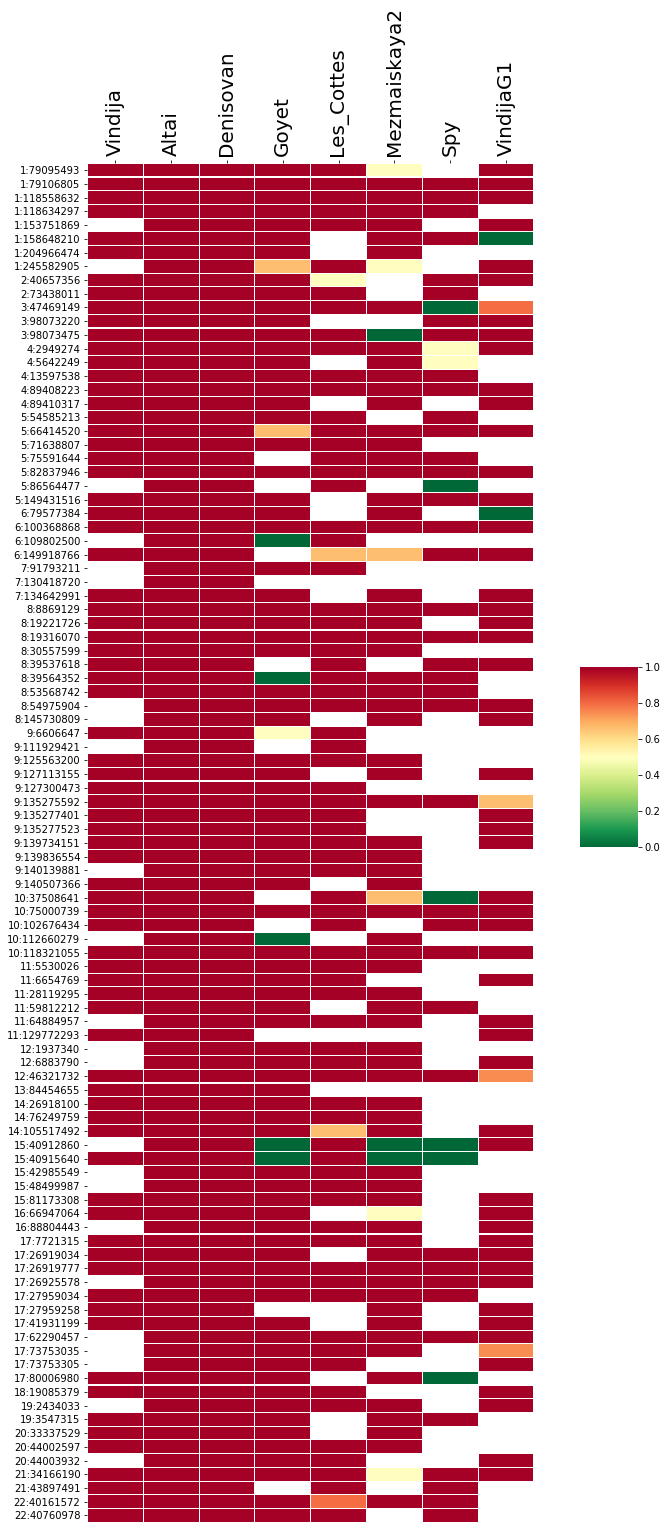

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(8,25))
cbar_ax = fig.add_axes([.98, .5, .1, .1])
sns.heatmap(proportions, cmap='RdYlGn_r', linewidths=0.1, ax=ax, cbar_ax=cbar_ax, cbar=True)
ax.xaxis.tick_top()
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90, size=20, horizontalalignment='center')

I can probably make this esthetically more pleasing, but it should be OK as a first shot.